<a href="https://colab.research.google.com/github/OpenMindPB/BasicPython/blob/main/Case_genial_RF_Parameter_Optimization_22_06_09_ucf3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalando e importando bibliotecas**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import datasets as ds
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

#**Coleta de dados**

In [2]:
data = ds.fetch_openml(data_id=151, as_frame=True, return_X_y=True)

(

    pd.concat(data, axis=1)

    .assign(target=lambda x: (x['class']=='UP')*1)

)

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class,target
0,0.0000,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP,1
1,0.0000,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP,1
2,0.0000,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP,1
3,0.0000,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP,1
4,0.0000,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,0
...,...,...,...,...,...,...,...,...,...,...
45307,0.9158,7,0.914894,0.044224,0.340672,0.003033,0.255049,0.405263,DOWN,0
45308,0.9158,7,0.936170,0.044884,0.355549,0.003072,0.241326,0.420614,DOWN,0
45309,0.9158,7,0.957447,0.043593,0.340970,0.002983,0.247799,0.362281,DOWN,0
45310,0.9158,7,0.978723,0.066651,0.329366,0.004630,0.345417,0.206579,UP,1


Trata-se de um problema de classificação binária.

# **Pré-processamento**

In [3]:
#print(data.DESCR)

In [4]:
type(data)

tuple

In [5]:
# Obteção das variáveis de entrada (features)
X=pd.DataFrame(data[0])

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45312 entries, 0 to 45311
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   date       45312 non-null  float64 
 1   day        45312 non-null  category
 2   period     45312 non-null  float64 
 3   nswprice   45312 non-null  float64 
 4   nswdemand  45312 non-null  float64 
 5   vicprice   45312 non-null  float64 
 6   vicdemand  45312 non-null  float64 
 7   transfer   45312 non-null  float64 
dtypes: category(1), float64(7)
memory usage: 2.5 MB


In [7]:
# Os dados da coluna " day" estão salvos como texto. Vamos transformá-los em inteiros
X['day'] = X['day'].astype(int)

In [8]:
# Obtenção das saídas (targets)
target = pd.DataFrame(data[1])

# Transformar dados categóricos em 0 e 1
y = pd.DataFrame(data[1]) # apenas para manter o target de
y['class'].replace(['UP', 'DOWN'],[1,0], inplace=True) 
y.head()

,class
0,1
1,1
2,1
3,1
4,0


In [9]:
# Obteção de um dataframe com entratas e saídas (para EDA)
total_data=pd.concat([X, y], axis=1)
total_data.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,1
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,1
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,1
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,1
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,0




# **Análise esploratória dos dados (EDA)**

In [10]:
total_data.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,0.499080,4.003178,0.500000,0.057868,0.425418,0.003467,0.422915,0.500526,0.424545
std,0.340308,1.998695,0.294756,0.039991,0.163323,0.010213,0.120965,0.153373,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031934,2.000000,0.250000,0.035127,0.309134,0.002277,0.372346,0.414912,0.000000
50%,0.456329,4.000000,0.500000,0.048652,0.443693,0.003467,0.422915,0.414912,0.000000
75%,0.880547,6.000000,0.750000,0.074336,0.536001,0.003467,0.469252,0.605702,1.000000
max,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


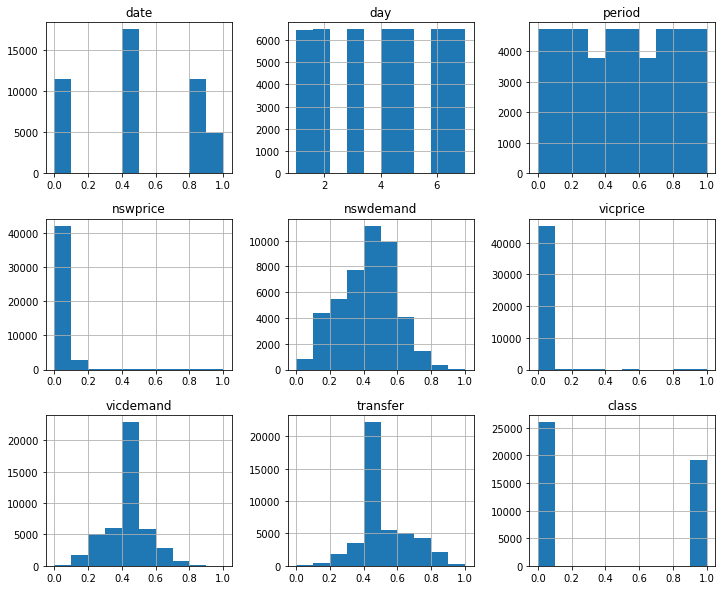

In [11]:
# Distribuíção de frequências das variáveis

total_data.hist(figsize=(12,10));

In [12]:
# Porcentagem entre as classes 
# up=1 down =0
up=total_data['class'].sum()/total_data['class'].count()
print('% up=',up*100)
print('% down=',(1-up)*100)

% up= 42.45453742937853
% down= 57.545462570621474


Classes estão relativamente balanceadas. Neste contexto, acurácia é um bom comparativo entre modelos

# **Escolha do Modelo**

Vamos testar os dados com alguns algorítimos adequados para classificação binária usando os hyperparâmetros defaut do método, e o mesmo random_state para excluir o efeito aleatoredade na performance. Em seguida, vamos calcular as métricas de desempenho e selecionar o modelo com melhor acurácia para proceguir a análise.

In [13]:
# Escalonando o modelo
scaler_x = MinMaxScaler().fit(X)
scaler_y = MinMaxScaler().fit(y)
Xscale=scaler_x.transform(X)
yscale=scaler_y.transform(y)

In [14]:
# Separação dos dados em treino e teste

X_train, X_test, y_train, y_test = \
    train_test_split(Xscale, yscale, test_size=0.30,  random_state=111, shuffle=True) # ps: shuffle= True default

### Randon Forest

In [15]:
rf = RandomForestClassifier(random_state=111) # create model
rf.fit(X_train, y_train) # training model
y_pred = rf.predict(X_test) #prediction step
y_pred_train = rf.predict(X_train) #prediction train step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


### Árvore de decisão

In [16]:
'''dt = tree.DecisionTreeClassifier( random_state=111)
dt.fit(X_train, y_train) # training model
y_pred_dt = dt.predict(X_test) #prediction step
y_pred_train_dt = dt.predict(X_train)  #prediction train step'''

'dt = tree.DecisionTreeClassifier( random_state=111)\ndt.fit(X_train, y_train) # training model\ny_pred_dt = dt.predict(X_test) #prediction step\ny_pred_train_dt = dt.predict(X_train)  #prediction train step'

### Regressão Logística

In [17]:
'''lr= LogisticRegression( random_state=111)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test) #prediction step
y_pred_train_lr = lr.predict(X_train)  #prediction train step'''

'lr= LogisticRegression( random_state=111)\nlr.fit(X_train, y_train)\ny_pred_lr = lr.predict(X_test) #prediction step\ny_pred_train_lr = lr.predict(X_train)  #prediction train step'

### Rede Neural Artificial - MLP

In [18]:
'''ann = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100, ), random_state=111)
ann.fit(X_train, y_train)
y_pred_ann=ann.predict(X_test)
y_pred_train_ann = ann.predict(X_train)  #prediction train step'''

"ann = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100, ), random_state=111)\nann.fit(X_train, y_train)\ny_pred_ann=ann.predict(X_test)\ny_pred_train_ann = ann.predict(X_train)  #prediction train step"

### XGBoost

In [19]:
'''xgb = XGBClassifier(random_state=111)
xgb.fit(X_train, y_train)
# make predictions for test data
y_pred_xgb = xgb.predict(X_test)
y_pred_train_xgb = xgb.predict(X_train)  #prediction train step
predictions = [round(value) for value in y_pred_xgb]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# plot feature importance
plot_importance(xgb)
plt.show()'''

'xgb = XGBClassifier(random_state=111)\nxgb.fit(X_train, y_train)\n# make predictions for test data\ny_pred_xgb = xgb.predict(X_test)\ny_pred_train_xgb = xgb.predict(X_train)  #prediction train step\npredictions = [round(value) for value in y_pred_xgb]\n# evaluate predictions\naccuracy = accuracy_score(y_test, predictions)\nprint("Accuracy: %.2f%%" % (accuracy * 100.0))\n# plot feature importance\nplot_importance(xgb)\nplt.show()'

### LightGBM

In [20]:
'''LiGBM = LGBMClassifier(random_state=111)
LiGBM.fit(X_train, y_train)
y_pred_lgbm = LiGBM.predict(X_test) #prediction step
y_pred_train_lgbm = LiGBM.predict(X_train)  #prediction train step
'''

'LiGBM = LGBMClassifier(random_state=111)\nLiGBM.fit(X_train, y_train)\ny_pred_lgbm = LiGBM.predict(X_test) #prediction step\ny_pred_train_lgbm = LiGBM.predict(X_train)  #prediction train step\n'

### **Avaliação e comparação das métricas do modelo**

In [21]:
##### Avaliação das métricas do modelo treino

print('**********  Avaliação das métricas do modelo random forest ***********')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_train, y_pred_train)))
print(" Precisão: {0:.5f}".format(precision_score(y_train, y_pred_train)))
print("   Recall: {0:.5f}".format(recall_score(y_train, y_pred_train)))
print(" f1 score: {0:.5f}".format(f1_score(y_train, y_pred_train)))
print()

'''print('**********  Avaliação das métricas do modelo Decision Tree Classifier ***********')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_train, y_pred_train_dt)))
print(" Precisão: {0:.5f}".format(precision_score(y_train, y_pred_train_dt)))
print("   Recall: {0:.5f}".format(recall_score(y_train, y_pred_train_dt)))
print(" f1 score: {0:.5f}".format(f1_score(y_train, y_pred_train_dt)))
print()

print('**********  Avaliação das métricas do modelo Logistic Regression ***********')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_train, y_pred_train_lr)))
print(" Precisão: {0:.5f}".format(precision_score(y_train, y_pred_train_lr)))
print("   Recall: {0:.5f}".format(recall_score(y_train, y_pred_train_lr)))
print(" f1 score: {0:.5f}".format(f1_score(y_train, y_pred_train_lr)))
print()

print('**********  Avaliação das métricas do modelo rede neural ***********')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_train, y_pred_train_ann)))
print(" Precisão: {0:.5f}".format(precision_score(y_train, y_pred_train_ann)))
print("   Recall: {0:.5f}".format(recall_score(y_train, y_pred_train_ann)))
print(" f1 score: {0:.5f}".format(f1_score(y_train, y_pred_train_ann)))
print()

print('**********  Avaliação das métricas do modelo XGB ***********')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_train, y_pred_train_xgb)))
print(" Precisão: {0:.5f}".format(precision_score(y_train, y_pred_train_xgb)))
print("   Recall: {0:.5f}".format(recall_score(y_train, y_pred_train_xgb)))
print(" f1 score: {0:.5f}".format(f1_score(y_train, y_pred_train_xgb)))
print()

print('**********  Avaliação das métricas do modelo light GBM ***********')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_train, y_pred_train_lgbm)))
print(" Precisão: {0:.5f}".format(precision_score(y_train, y_pred_train_lgbm)))
print("   Recall: {0:.5f}".format(recall_score(y_train, y_pred_train_lgbm)))
print(" f1 score: {0:.5f}".format(f1_score(y_train, y_pred_train_lgbm)))
print()'''

**********  Avaliação das métricas do modelo random forest ***********

 Acurácia: 1.00000
 Precisão: 1.00000
   Recall: 1.00000
 f1 score: 1.00000



'print(\'**********  Avaliação das métricas do modelo Decision Tree Classifier ***********\')\nprint()\nprint(" Acurácia: {0:.5f}".format(accuracy_score(y_train, y_pred_train_dt)))\nprint(" Precisão: {0:.5f}".format(precision_score(y_train, y_pred_train_dt)))\nprint("   Recall: {0:.5f}".format(recall_score(y_train, y_pred_train_dt)))\nprint(" f1 score: {0:.5f}".format(f1_score(y_train, y_pred_train_dt)))\nprint()\n\nprint(\'**********  Avaliação das métricas do modelo Logistic Regression ***********\')\nprint()\nprint(" Acurácia: {0:.5f}".format(accuracy_score(y_train, y_pred_train_lr)))\nprint(" Precisão: {0:.5f}".format(precision_score(y_train, y_pred_train_lr)))\nprint("   Recall: {0:.5f}".format(recall_score(y_train, y_pred_train_lr)))\nprint(" f1 score: {0:.5f}".format(f1_score(y_train, y_pred_train_lr)))\nprint()\n\nprint(\'**********  Avaliação das métricas do modelo rede neural ***********\')\nprint()\nprint(" Acurácia: {0:.5f}".format(accuracy_score(y_train, y_pred_train_ann))

In [22]:
##### Avaliação das métricas do modelo teste

print('**********  Avaliação das métricas do modelo random forest ***********')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_test, y_pred)))
print(" Precisão: {0:.5f}".format(precision_score(y_test, y_pred)))
print("   Recall: {0:.5f}".format(recall_score(y_test, y_pred)))
print(" f1 score: {0:.5f}".format(f1_score(y_test, y_pred)))
print()
'''
print('**********  Avaliação das métricas do modelo Decision Tree Classifier ***********')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_test, y_pred_dt)))
print(" Precisão: {0:.5f}".format(precision_score(y_test, y_pred_dt)))
print("   Recall: {0:.5f}".format(recall_score(y_test, y_pred_dt)))
print(" f1 score: {0:.5f}".format(f1_score(y_test, y_pred_dt)))
print()

print('**********  Avaliação das métricas do modelo Logistic Regression ***********')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_test, y_pred_lr)))
print(" Precisão: {0:.5f}".format(precision_score(y_test, y_pred_lr)))
print("   Recall: {0:.5f}".format(recall_score(y_test, y_pred_lr)))
print(" f1 score: {0:.5f}".format(f1_score(y_test, y_pred_lr)))
print()

print('**********  Avaliação das métricas do modelo rede neural ***********')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_test, y_pred_ann)))
print(" Precisão: {0:.5f}".format(precision_score(y_test, y_pred_ann)))
print("   Recall: {0:.5f}".format(recall_score(y_test, y_pred_ann)))
print(" f1 score: {0:.5f}".format(f1_score(y_test, y_pred_ann)))
print()

print('**********  Avaliação das métricas do modelo XGB ***********')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_test, y_pred_xgb)))
print(" Precisão: {0:.5f}".format(precision_score(y_test, y_pred_xgb)))
print("   Recall: {0:.5f}".format(recall_score(y_test, y_pred_xgb)))
print(" f1 score: {0:.5f}".format(f1_score(y_test, y_pred_xgb)))
print()

print('**********  Avaliação das métricas do modelo light GBM ***********')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_test, y_pred_lgbm)))
print(" Precisão: {0:.5f}".format(precision_score(y_test, y_pred_lgbm)))
print("   Recall: {0:.5f}".format(recall_score(y_test, y_pred_lgbm)))
print(" f1 score: {0:.5f}".format(f1_score(y_test, y_pred_lgbm)))
print()'''

**********  Avaliação das métricas do modelo random forest ***********

 Acurácia: 0.90356
 Precisão: 0.90492
   Recall: 0.86295
 f1 score: 0.88344



'\nprint(\'**********  Avaliação das métricas do modelo Decision Tree Classifier ***********\')\nprint()\nprint(" Acurácia: {0:.5f}".format(accuracy_score(y_test, y_pred_dt)))\nprint(" Precisão: {0:.5f}".format(precision_score(y_test, y_pred_dt)))\nprint("   Recall: {0:.5f}".format(recall_score(y_test, y_pred_dt)))\nprint(" f1 score: {0:.5f}".format(f1_score(y_test, y_pred_dt)))\nprint()\n\nprint(\'**********  Avaliação das métricas do modelo Logistic Regression ***********\')\nprint()\nprint(" Acurácia: {0:.5f}".format(accuracy_score(y_test, y_pred_lr)))\nprint(" Precisão: {0:.5f}".format(precision_score(y_test, y_pred_lr)))\nprint("   Recall: {0:.5f}".format(recall_score(y_test, y_pred_lr)))\nprint(" f1 score: {0:.5f}".format(f1_score(y_test, y_pred_lr)))\nprint()\n\nprint(\'**********  Avaliação das métricas do modelo rede neural ***********\')\nprint()\nprint(" Acurácia: {0:.5f}".format(accuracy_score(y_test, y_pred_ann)))\nprint(" Precisão: {0:.5f}".format(precision_score(y_test, 

# **...**


In [23]:
###### Entendimento do efeito das variáveis de entrada

print('*********** Efeito das variáveis de entrada (features)  ***********')
print()
ft_imp = pd.Series(rf.feature_importances_).sort_values(ascending=False) #obtenção dos efeitos
#Renomenando os índices:
df=pd.DataFrame(ft_imp)
df.index = X.columns[ft_imp.index]
#Renomeando a coluna:
df.columns=['Effect'] 
df

*********** Efeito das variáveis de entrada (features)  ***********



,Effect
nswprice,0.308497
date,0.173794
nswdemand,0.128352
vicprice,0.106449
period,0.105346
vicdemand,0.064744
transfer,0.056938
day,0.055880


Text(0.5, 0, 'Efeito')

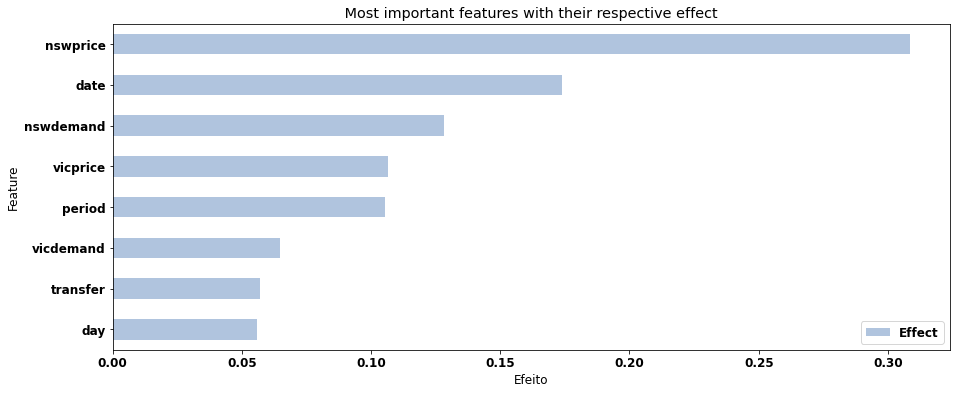

In [24]:
# #-------Vizualization-----------

# Let's print a chart containing the features whose effect is at least around 5%

df1=df.sort_values(by=['Effect'], ascending=True) # sort in ascending order for plot


font = {'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [15, 6] 

df1.plot(kind='barh', color='lightsteelblue')
plt.title(' Most important features with their respective effect ')
plt.ylabel('Feature')
plt.xlabel('Efeito')

# **Ajuste dos hiperpararâmetros do modelo selecionado - Random Forest**

In [25]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
param_grid = { 
    'n_estimators': [50,100],
    'max_features': [3,6,9],
    'max_depth' : [None],
    'criterion' :['gini', 'entropy']
}
rf = RandomForestClassifier(random_state=111) # create model
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=111),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None],
                         'max_features': [3, 6, 9], 'n_estimators': [50, 100]})

In [26]:
CV_rf.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 6,
 'n_estimators': 100}

In [27]:
y_pred = CV_rf.predict(X_test) #prediction step
y_pred_train = CV_rf.predict(X_train) #prediction train step

In [28]:
##### Avaliação das métricas do modelo treino após otimização

print('**********  Avaliação das métricas do modelo random forest após otimização ***********')
print('Conjunto Treino')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_train, y_pred_train)))
print(" Precisão: {0:.5f}".format(precision_score(y_train, y_pred_train)))
print("   Recall: {0:.5f}".format(recall_score(y_train, y_pred_train)))
print(" f1 score: {0:.5f}".format(f1_score(y_train, y_pred_train)))
print()
print('Conjunto Teste')
print()
print('**********  Avaliação das métricas do modelo random forest ***********')
print()
print(" Acurácia: {0:.5f}".format(accuracy_score(y_test, y_pred)))
print(" Precisão: {0:.5f}".format(precision_score(y_test, y_pred)))
print("   Recall: {0:.5f}".format(recall_score(y_test, y_pred)))
print(" f1 score: {0:.5f}".format(f1_score(y_test, y_pred)))
print()

**********  Avaliação das métricas do modelo random forest após otimização ***********
Conjunto Treino

 Acurácia: 1.00000
 Precisão: 1.00000
   Recall: 1.00000
 f1 score: 1.00000

Conjunto Teste

**********  Avaliação das métricas do modelo random forest ***********

 Acurácia: 0.92482
 Precisão: 0.91970
   Recall: 0.90116
 f1 score: 0.91034

